# Tutorial. Numerical methods for ordinary differential equations

A general technique for solving problems with partial differential equations (PDE) that involve a time variable $t$ and one or more space variables is the so-called [method of lines](https://en.wikipedia.org/wiki/Method_of_lines). It proceeds by first discretising the partial derivatives with respect to the space variables and leaving the time variable continuous, leadind to an approximating system of ordinary differential equations (ODE) in the variable $t$. The Cauchy problem for the resulting ordinary differential equations is then solved using a standard method for the task.

The convenience and versatility of readily available ordinary differential equation solvers permits complicated partial differential equations to be solved with comparative ease in this manner, especially when there is only one space variable. Note that it might well be more efficient to solve a given partial differential equation by a method particularly suited to the equation, but the easy solution of rather general problems with acceptable accuracy makes the approach of the method of lines attractive.

In the present notebook, we are interested in reviewing some of the most basic numerical methods to solve Cauchy problems for an ordinary differential equation of the form:
$$
\begin{cases}
u'(t)=f(t,u(t)),\ t>0,\\
u(0) = u_0,
\end{cases}
$$
where $u$ is a function typically taking its values in $\mathbb{R}^d$ (in the method of lines, the integer $d$ is the dimension of the semi-discretised partial differential equation problem).

For this notebook, we will need the <tt>numpy</tt> and <tt>matplotlib</tt> packages.

In [1]:
import numpy as np

# To draw matplotlib plots within this notebook.
# %matplotlib inline
import matplotlib.pyplot as plt

## Exercise 1. The SIR model.
Consider the system of the Kermack-McKendrick [SIR model](http://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model), describing the evolution of a population affected by an infectious disease
$$
\left\{
\begin{align*}
S'(t)&=-r\,S(t)I(t),\\
I'(t)&=r\,S(t)I(t)-a\,I(t),\\
R'(t)&=a\,I(t),
\end{align*}
\right.\ t>0,
$$
associated with the initial data
$$
S(0)=S_0,\ I(0)=I_0,\ R(0)=R_0.
$$
The functions $S$, $I$, and $R$ represent the numbers of people respectively susceptible to the disease, infected by the disease, and immune after being infected over time, the real number $r$ is the infection rate, and the real number $a$ is the rate of recovery. We will use the following values for the problem parameters:

$$
S_0=762,\ I_0=1,\ R_0=0,\ r=0.00218,\ a=0.44036,\ T=14,
$$

obtained by calibrating the model using data from an influenza epidemic in a boys' school published in the British medical journal *The Lancet* on March 4, 1978.

**Question.** Compute an approximate solution of the system on the time interval $[0,T]$ using the [explicit (or forward) Euler method](https://en.wikipedia.org/wiki/Euler_method) and $N=10^5$ discretisation steps. To do this, write an independent function `explicit_euler` implementing the method (it will be used in other exercises), whose inputs are the function $f$ in the right-hand side of the ODE, the initial and final values of the time variable, the initial datum of the problem, the number of steps used for the uniform discretisation grid, and whose outputs are two arrays containing respectively the values of the times at which the approximation of the solution is computed and the corresponding values of this approximation. Represent the time evolution of the values of the approximations obtained for the numbers $S(t)$, $I(t)$ and $R(t)$.

**Answer.**

In [2]:
def SIR(t: float, x: np.ndarray, r: float = 0.00218,a: float = 0.44036) -> np.ndarray:
    S,I,R=x[0],x[1],x[2]
    return np.array([-r*S*I, r*S*I-a*I, a*I])

def explicit_euler(f, x0:np.ndarray, t0: float, t1: float, N: int):
    t=np.linspace(t0,t1,N+1)
    h=(t1-t0)/N
    u=[x0[0]]
    for i in range(N):
        u.append(u[-1]+h*f(t[i],u[-1]))
    return t, u

In [3]:
# r,a=0.00218,0.44036
# def f(t,u): return np.array([-r*u[0]*u[1],r*u[0]*u[1]-a*u[1],a*u[1]])
u0=np.array([[762.,1.,0]])
t0,t1=0,14
N=100000
t,x=explicit_euler(SIR,u0,t0,t1,N)
x=np.array(x)

**Question.** Let $N$ denote the number of discretisation steps used. Check theoretically and numerically that the obtained approximation verifies, for all $0\leq n\leq N$,
$$
S_n+I_n+R_n=S_0+I_0+R_0.
$$

**Answer.**

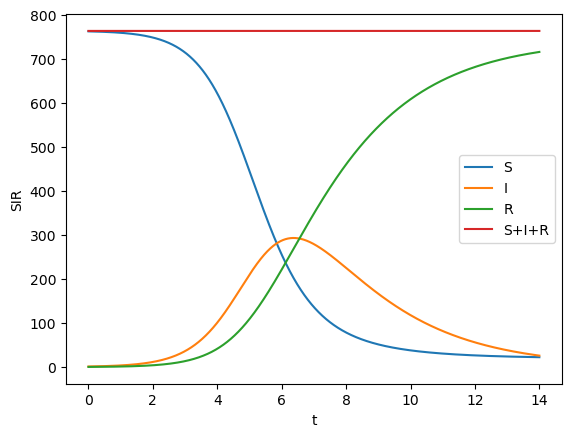

In [4]:
# print a SIR graphic
plt.plot(t, x[:,0], label='S')
plt.plot(t, x[:,1], label='I')
plt.plot(t, x[:,2], label='R')
# sum of S,I,R
plt.plot(t, x[:,0]+x[:,1]+x[:,2], label='S+I+R')
plt.legend()
plt.xlabel('t')
plt.ylabel('SIR')
plt.show()

**Question.** Taking as reference solution the one obtained with $N=10^5$ discretisation steps, represent (using a logarithmic scale) the errors at time $T$ found using successively $N=10,10^2,\dots,10^4$ discretisation steps and determine the effective order of convergence of the method using the ``polyfit`` function from <tt>numpy</tt>.

**Answer.**

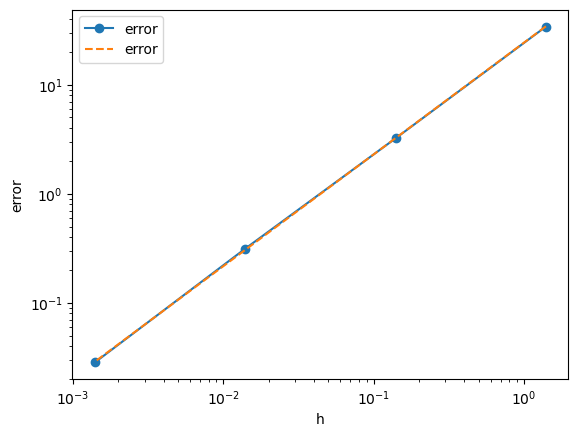

The effective order of the Euler explicit method is 1.024114015667395


In [6]:
N=100000
t,x=explicit_euler(SIR,u0,t0,t1,N)
x=np.array(x)
NN = [10, 100, 1000, 10000]
errors=[]
T = 14
hh = [T / N for N in NN]
errors = []
for N in NN:
    tt, xx = explicit_euler(SIR, u0, t0, t1, N)
    xx = np.array(xx)
    errors.append(np.linalg.norm(xx[-1] - x[-1]))
slope = np.polyfit(np.log(hh), np.log(errors), 1)
plt.loglog(
    hh,
    errors,
    'o-',
    hh,
    np.exp(
        slope[1]) *
    hh**slope[0],
    '--',
    label='error')
plt.legend()
plt.xlabel('h')
plt.ylabel('error')
plt.show()
print("The effective order of the Euler explicit method is", slope[0])


**Question.** Write, on the model of the `explicit_euler` function, a function named `rk4` for the ["classic" Runge--Kutta method of order four](https://en.wikipedia.org/wiki/Runge–Kutta_methods#The_Runge–Kutta_method). The Butcher tableau of the method is
$$
\begin{array}{c|cccc}
0\\
\frac{1}{2}&\frac{1}{2}\\
\frac{1}{2}&0&\frac{1}{2}\\
1&0&0&1\\
\hline
&\frac{1}{6}&\frac{1}{3}&\frac{1}{3}&\frac{1}{6}
\end{array}.
$$
Determine the effective order of this method by proceeding as in the previous question.

In [9]:
def rk4(f, x0: np.ndarray, t0: float, t1: float, N: int):
    t=np.linspace(t0,t1,N+1)
    h=(t1-t0)/N
    u=[x0[0]]
    for i in range(N):
        k1=f(t[i],u[-1])
        k2=f(t[i]+h/2,u[-1]+h/2*k1)
        k3=f(t[i]+h/2,u[-1]+h/2*k2)
        k4=f(t[i]+h,u[-1]+h*k3)
        u.append(u[-1]+h/6*(k1+2*(k2+k3)+k4))
    return t, u   

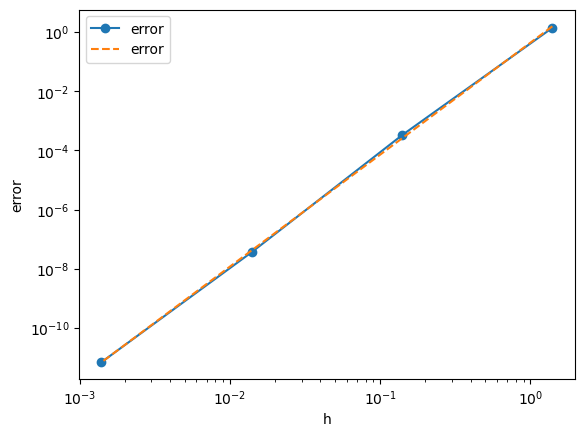

The effective order of the RK4 method is 3.7874189933658546


In [10]:
N=100000
t,x=rk4(SIR,u0,t0,t1,N)
x=np.array(x)
NN=[10,100,1000,10000]
T=14
hh=[T/N for N in NN]
errors=[]
for N in NN:
    tt,xx=rk4(SIR,u0,t0,t1,N)
    xx=np.array(xx)
    errors.append(np.linalg.norm(xx[-1]-x[-1]))
slope=np.polyfit(np.log(hh),np.log(errors),1)
plt.loglog(hh,errors,'o-',hh,np.exp(slope[1])*hh**slope[0],'--',label='error')
plt.legend()
plt.xlabel('h')
plt.ylabel('error')
plt.show()
print("The effective order of the RK4 method is", slope[0])


## Exercise 2. The Dahlquist test equation.

The goal of this exercise is to use several one-step methods to numerically solve a problem based on the Dahlquist test equation, that is the following autonomous differential equation:
$$
u'(t)=\alpha u(t),\ t>0,
$$
where $u$ takes its values in $\mathbb{C}$ and $\alpha$ belongs to $\mathbb{C}$, completed by the initial condition
$$
u(0) = 1,
$$
up to a given final time $T$. The unique solution of this Cauchy problem possesses a closed-form expression, given by
$$
u(t) = e^{\alpha t}.
$$
When $\text{Re}(\alpha)<0$, this problem is at the basis of the notion of [A-stability](https://en.wikipedia.org/wiki/Stiff_equation#A-stability) for the behaviour of methods applied to the numerical solution of [stiff equations](https://en.wikipedia.org/wiki/Stiff_equation).

In what follows, we denote by $N$ the number of steps in the uniform grid discretising the interval $[0,T]$ and by $\Delta t=\frac{T}{N}$ the length of a step. We will denote by $u^{(n)}_{\text{*}}$ the numerical approximation of the exact value $u(n \Delta t)$,  where the character * refers to the selected method.

The chosen values of the parameters are $T=10$ and $N=100$.

In [11]:
T=10.
N=100

**Question.** Using each of the following methods, numerically solve the Cauchy problem and plot both the numerical solution and the exact solution for several (both positive and negative) real values of $\alpha$. Are some numerical instabilities observed?

**a. The explicit Euler method.** For this method, use the function written in the previous exercise.

In [12]:
def f(t,u): return alpha*u

u0=np.array([1.])

**Answer.**

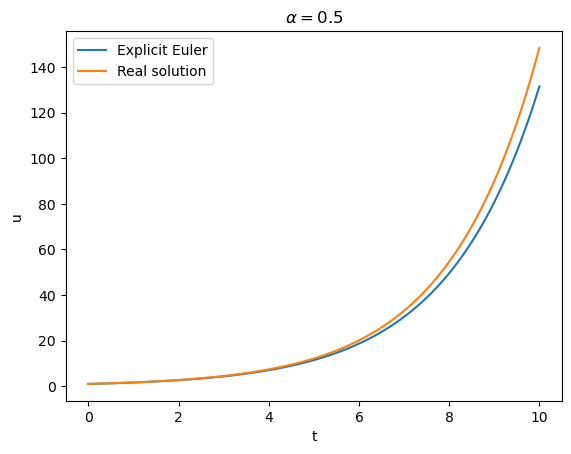

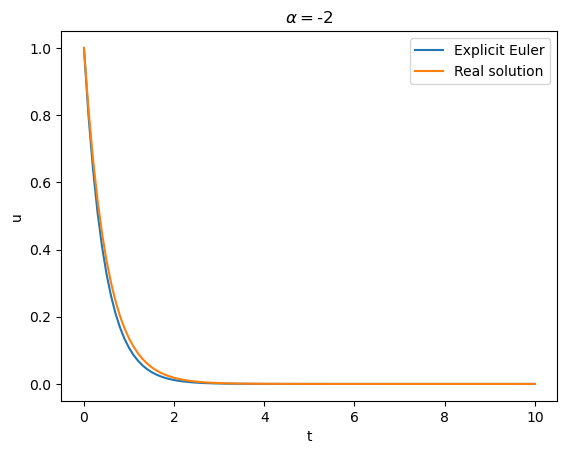

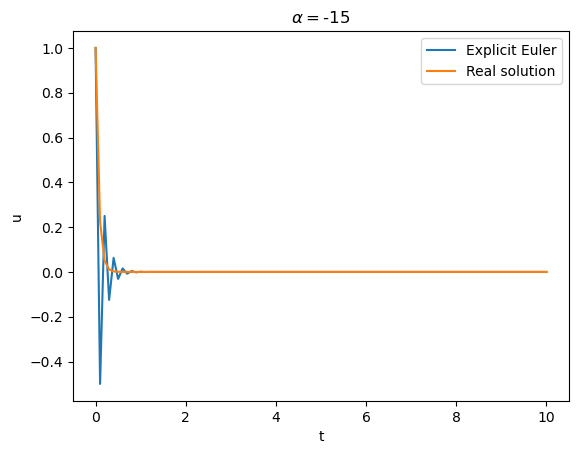

In [13]:
Alpha=[0.5,-2,-15]
for alpha in Alpha:
  t,u=explicit_euler(f,u0,0,T,N)
  # plot the result
  plt.plot(t,u,label='Explicit Euler')
  # real solution exp(alpha*t)
  plt.plot(t,np.exp(alpha*t),label='Real solution')
  plt.title(r'$\alpha=$'+str(alpha))
  plt.legend()
  plt.xlabel('t')
  plt.ylabel('u')
  plt.show()

**b. The implicit Euler method.** Recall that the [implicit (or backward) Euler method](https://en.wikipedia.org/wiki/Backward_Euler_method) is another first-order one-step method, defined by the recurrence relation
$$
u^{(n+1)}_{\text{IE}}=u^{(n)}_{\text{IE}}+h\,f((n+1)h,u^{(n+1)}_{\text{IE}}),
$$
in which $h$ is the fixed steplength. To determine $u^{(n+1)}_{\text{IE}}$ at each step, the (possibly nonlinear) equation above has to be solved numerically, using for instance the `optimize.fsolve` function from <tt>scipy</tt>.

In [14]:
from scipy.optimize import fsolve

**Answer.**

In [15]:
def implicit_euler(f, x0: np.ndarray, t0: float, t1: float, N: int):
    t = np.linspace(t0, t1, N + 1)
    h = (t1 - t0) / N
    u = [x0[0]]
    for i in range(N):
        # solve the nonlinear equation with optimize.fsolve
        u.append(fsolve(lambda x: x - u[-1] - h * f(t[i + 1], x), u[-1],xtol=1e-8)[0])
    return t, u


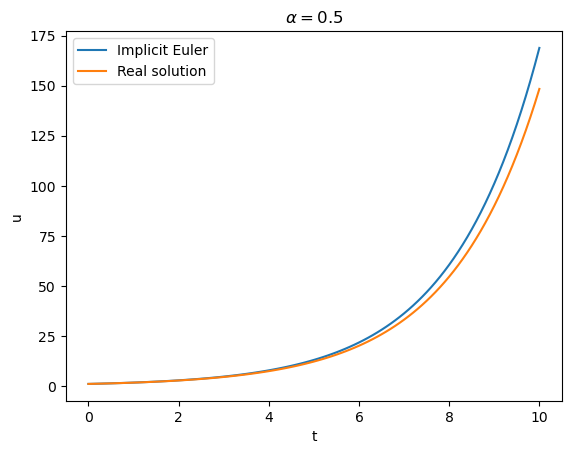

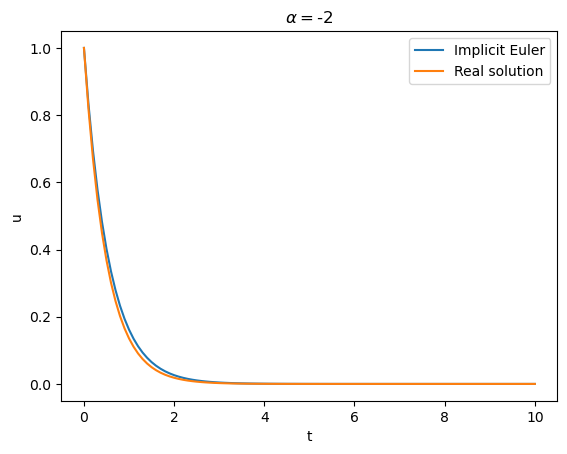

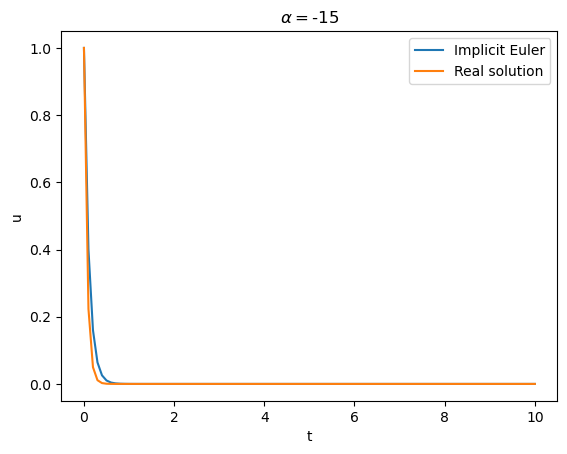

In [16]:
Alpha = [0.5, -2, -15]
for alpha in Alpha:
  t, u = implicit_euler(f, u0, 0, T, N)
  # plot the result
  plt.plot(t, u, label='Implicit Euler')
  # real solution exp(alpha*t)
  plt.plot(t, np.exp(alpha * t), label='Real solution')
  plt.title(r'$\alpha=$' + str(alpha))
  plt.legend()
  plt.xlabel('t')
  plt.ylabel('u')
  plt.show()


**c. The trapezoidal rule.** The [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule_(differential_equations)) is an implicit one-step method, which can be considered as both a [Runge–Kutta method](https://en.wikipedia.org/wiki/Runge–Kutta_methods) and a [linear multistep method](https://en.wikipedia.org/wiki/Linear_multistep_method) of Adams-Moulton type, defined by the following recursion relation
$$
u^{(n+1)}_{\text{TR}}=u^{(n)}_{\text{TR}}+\frac{h}{2}\,\left(f(nh,u^{(n)}_{\text{TR}})+f((n+1)h,u^{(n+1)}_{\text{TR}})\right),
$$
in which $h$ is the fixed spacing.

**Preliminary question.** Show that the trapezoidal rule method is a second-order method.

**Answer.**

An easy Taylor-expansion shows that the trapezoidal rule method is a second-order method.

**Answer.**

In [17]:
def trapezoidal(f, x0: np.ndarray, t0: float, t1: float, N: int):
    t = np.linspace(t0, t1, N + 1)
    h = (t1 - t0) / N
    u = [x0[0]]
    for i in range(N):
        # solve the nonlinear equation with optimize.fsolve
        u.append(fsolve(lambda x: x - u[-1] - h / 2 * (f(t[i], u[-1]) + f(t[i + 1], x)), u[-1],xtol=1e-8)[0])
    return t, u

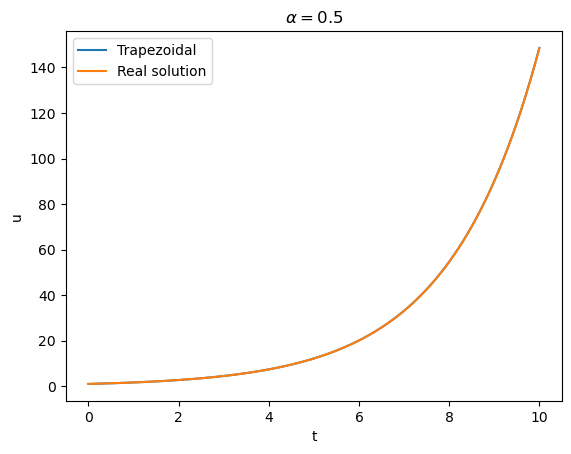

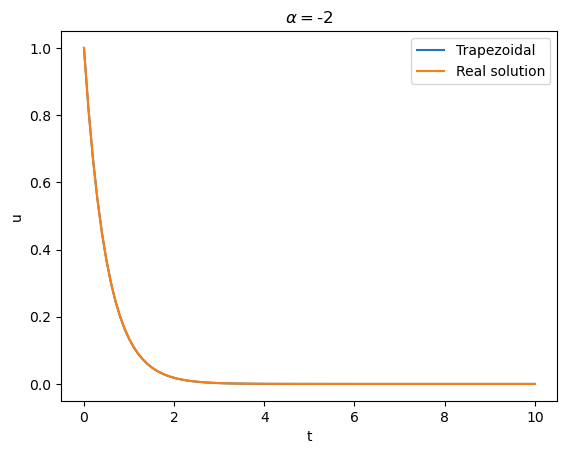

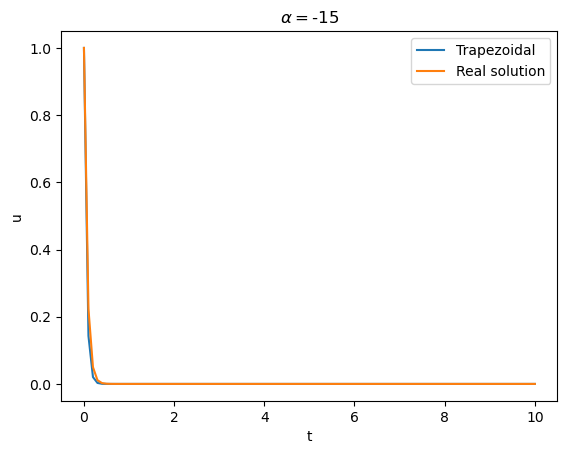

In [18]:
Alpha = [0.5, -2, -15]
for alpha in Alpha:
  t, u = trapezoidal(f, u0, 0, T, N)
  # plot the result
  plt.plot(t, u, label='Trapezoidal')
  # real solution exp(alpha*t)
  plt.plot(t, np.exp(alpha * t), label='Real solution')
  plt.title(r'$\alpha=$' + str(alpha))
  plt.legend()
  plt.xlabel('t')
  plt.ylabel('u')
  plt.show()


## Exercise 3. A second-order differential equation: the harmonic oscillator.

We consider the following Cauchy problem:
$$\begin{cases}
u''(t)+\omega^2u(t)=0,\ t>0,\\
u(0)=1,\\
u'(0)=0,
\end{cases}
$$
to be solved up to time $T$, where $u$ takes its values in $\mathbb{R}$, $\omega$ being a given real number.

**Question.** Introducing the function $v=\frac{u'}{\omega}$, show that this system is equivalent to a complex exponential system such as defined in the previous exercise. Express $\alpha$ in terms of $\omega$.

**Answer.**

Note that if $u'=v\omega$, we can write the system as:
$$
\begin{cases}
u'=\omega v\\
v'=-\omega u\\
u(0)=1\\
v(0)=0
\end{cases}
$$

Now set $z=u+iv$, then $z'=u'+iv'=\omega v-i\omega u=-\mathrm{i}\omega z$. So $\alpha=-\mathrm{i}\omega$ in the previous exercise.

**Question.** Solve numerically the resulting system for $\omega = 1$ using the explicit Euler method, the implicit Euler method, and the trapezoidal rule method.

In [19]:
omega=1.
alpha=omega*np.array([[0.,-1.],[1.,0.]])

def f(t,x): return alpha.dot(x)

T=20.
N=500

u0=np.array([1.,0.])

**Question.** Plot the respective [phase portraits](https://en.wikipedia.org/wiki/Phase_portrait) of the numerical approximations (that is, plot the approximations in the $(u,v)$-plane).

**Question.** If one wants to enforce energy conservation in this system, which numerical method should be preferably used? Explain theoretically what is observed with the selected numerical method.

**Answer.**

## Exercise 4. Stiff equation and absolute stability.
We want to approximate numerically the solution to the Cauchy problem
$$
\begin{cases}
u'(t)=-50\,\left(u(t)-\sin(t)\right)+\cos(t),& t>0,\\
u(0)=1,
\end{cases}
$$
on the interval $[0,2]$. 

**Question :** Use the explicit Euler method to solve the problem with a discretisation step of constant length, successively chosen

- strictly greater than 0.04, 
- between 0.02 and 0.04,
- strictly less than 0.02.

What is observed and what explanation can be given?

In [20]:
def f(t,u): return -50*(u-np.sin(t))+np.cos(t)

u0=np.array([1.])

**Answer :**

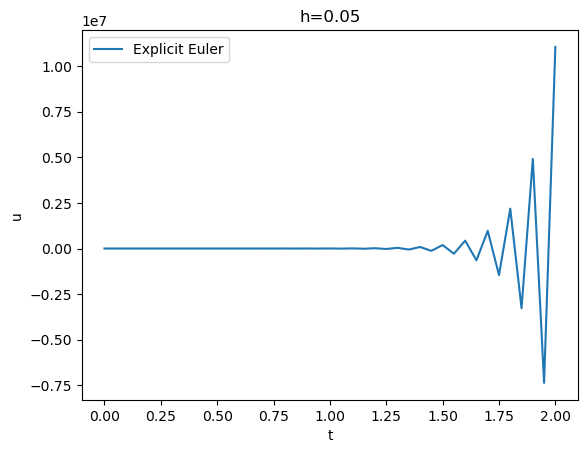

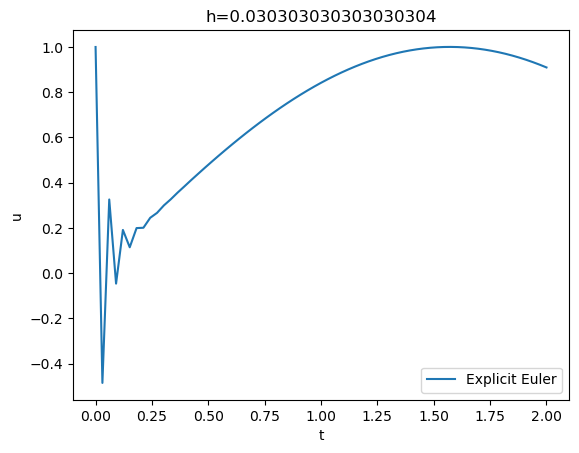

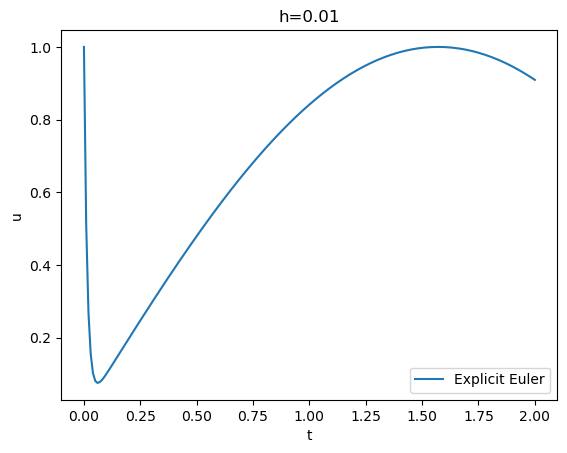

In [21]:
T=2
hh=[0.05,0.03,0.01]
NN=[int(T/h) for h in hh]
for N in NN:
  t,u=explicit_euler(f,u0,0,T,N)
  # plot the result
  plt.plot(t,u,label='Explicit Euler')
  plt.title('h='+str(T/N))
  plt.legend()
  plt.xlabel('t')
  plt.ylabel('u')
  plt.show()

The above differential equation is an example of a [stiff equation](http://en.wikipedia.org/wiki/Stiff_equation), whose solution can be written as the sum of a fast and a slow component.

**Question.** Determine the closed form of the solution and identify its respective fast and slow components.

**Answer.**

The solution of the ode is
$$
  u(t)=C\mathrm{e}^{-50t}+\sin(t).
$$
And imposing that $u(0)=1$ we get $C=1-\sin(0)=1$. So:
$$
  u(t)=\mathrm{e}^{-50t}+\sin(t).
$$
Clearly the fast component is $\mathrm{e}^{-50t}$ and the slow component is $\sin(t)$.

From a numerical point of view, one calls *stiff* any system of ordinary differential equations for which an explicit numerical solution method presents problems of numerical instability, unless the discretisation step length is extremely small (or, to be more precise, much smaller than would be required in principle for the accuracy required when using a step adaptation mechanism). The simulations previously performed indicate that we are here faced by such an equation.

**Question :** Perform the previous calculations using this time the implicit Euler method. Conclude.

**Answer :**

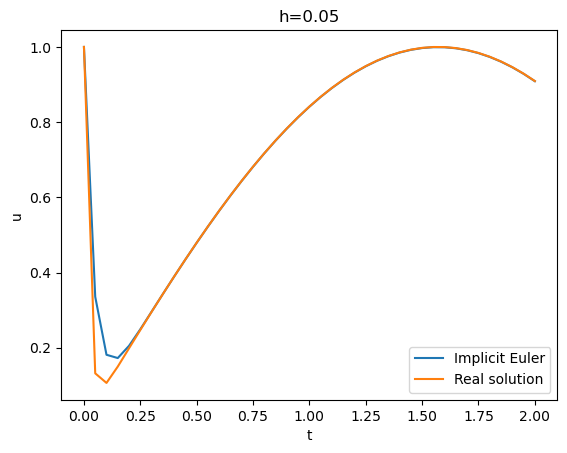

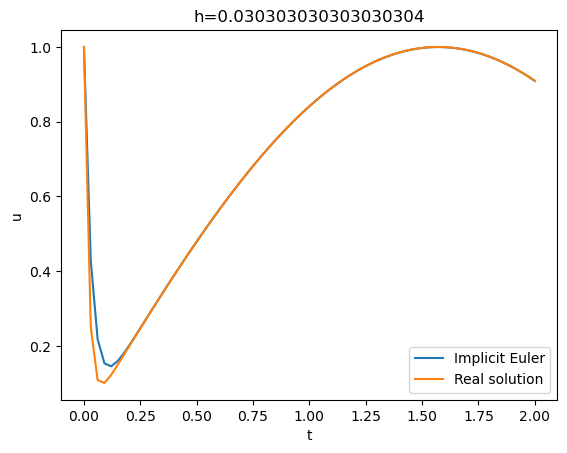

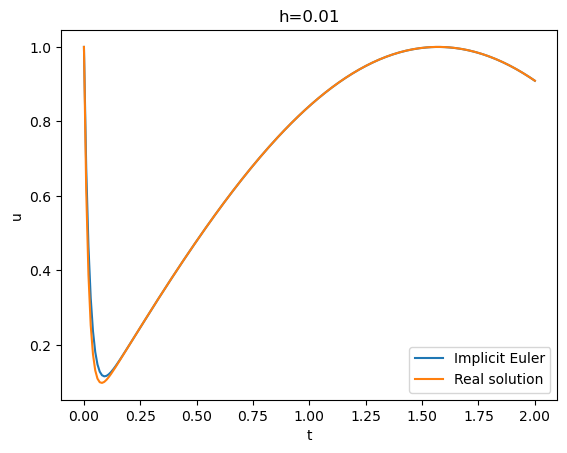

In [22]:
T = 2
hh = [0.05, 0.03, 0.01]
NN = [int(T / h) for h in hh]
for N in NN:
  t, u = implicit_euler(f, u0, 0, T, N)
  # plot the result
  plt.plot(t, u, label='Implicit Euler')
  # real solution exp(-50*t)+sin(t)
  plt.plot(t, np.exp(-50 * t) + np.sin(t), label='Real solution')
  plt.title('h=' + str(T / N))
  plt.legend()
  plt.xlabel('t')
  plt.ylabel('u')
  plt.show()


## Exercise 5. A chaotic dynamical system: the Lorenz system.

We are interested in [the Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system), first studied by the mathematician and meteorologist Edward Lorenz to model the atmospheric convection. It is defined as the following system of differential equations:
$$
\begin{cases}
x'(t)= \sigma(y(t) - x(t))\\
y'(t)= x(t)(\rho - z(t)) - y(t)\\
z'(t)= x(t)y(t) - \beta z(t)
\end{cases},\ t>0,
$$
completed by initial conditions, where $x, y, z : \mathbb{R} \rightarrow \mathbb{R}$ and the real numbers $\sigma$, $\rho$ and $\beta$ are fixed numerical parameters. In his experiments, Lorenz used the following values for these parameters: $\rho=28$, $\sigma=10$ and $\beta=\frac{8}{3}$.

In [23]:
rho = 28.
sigma = 10.
b = 8./3.

We want to numerically solve the resulting system using a two-stage [Runge--Kutta method](https://en.wikipedia.org/wiki/Runge–Kutta_methods), with Butcher's tableau
$$
\begin{array}{c|cc}
0&&\\
1&1&\\
\hline
&\frac{1}{2}&\frac{1}{2}
\end{array},
$$
called [Heun's method](https://en.wikipedia.org/wiki/Heun%27s_method).

**Question.** Show theoretically that Heun's method is a second-order method.

**Answer.**

First we write the Heun's method as:
$$
u^{(n+1)}=u^{(n)}+\frac{h}{2}\left(f(t_n,u^{(n)})+f(t_{n+1},u^{(n)}+hf(t_n,u^{(n)}))\right).
$$

And we expand using Taylor series.

**Question.** On the model of the previous functions, write an independent function named `rk2` implementing Heun's method.

In [24]:
def rk2(f, x0: np.ndarray, t0: float, t1: float, N: int):
    t = np.linspace(t0, t1, N + 1)
    h = (t1 - t0) / N
    u = [x0]
    for i in range(N):
        k1 = f(t[i], u[-1])
        k2 = f(t[i] + h, u[-1] + h * k1)
        u.append(u[-1] + h / 2 * (k1 + k2))
    return t, u

**Question.** Solve numerically the Lorenz system on the interval $[0,T]$ using Heun's method with the following initial values: $x (0) = y (0) = z (0) = 1$. We will use at least $T = 100$ and $N = 10000$.

In [25]:
def lorenz(t,u): return np.array([sigma*(u[1]-u[0]),u[0]*(rho-u[2])-u[1],u[0]*u[1]-b*u[2]])

In [26]:
T=100
N=10000
u0=np.array([1.,1.,1.])
t,u=rk2(lorenz,u0,0,T,N)
u=np.array(u)

**Question.** Plot the solution in the 3D-space $(x,y,z)$. The ``mplot3d`` toolkit can be used for generating 3D plots (see a [tutorial](https://matplotlib.org/stable/tutorials/toolkits/mplot3d.html)).

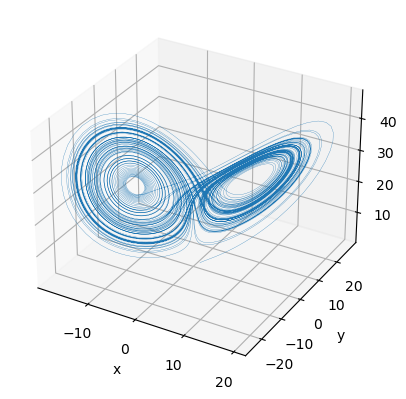

In [27]:
from mpl_toolkits.mplot3d import Axes3D
ax= plt.figure().add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# change line width
ax.plot(u[:,0],u[:,1],u[:,2],lw=0.2)
plt.show()

This figure is characteristic of the *Lorenz attractor*. For some specific values of its parameters, as those chosen here, the system is chaotic: this means that solutions are highly senstive to initial conditions (small changes in the initial conditions produce large changes in the solutions).

**Question.** For the same values of the parameters, slightly change the initial values and observe the chaotic behaviour of the solution.

**Answer.**

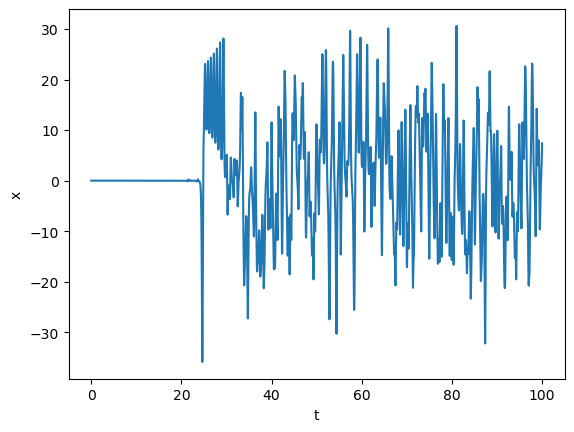

In [28]:
u0+=np.array([0.,0.,1e-6])
t,u2=rk2(lorenz,u0,0,T,N)
u2=np.array(u2)
# compare the two solutions
diff = u-u2
# we plot the difference between the two solutions in x
plt.plot(t,diff[:,0])
plt.xlabel('t')
plt.ylabel('x')
plt.show()

## Exercise 6. An Adams-Bashforth method.
When using one previous approximate value to compute the next one in a one-step method, the only way to improve the accuracy is to resort to a [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge–Kutta_methods) with more stages. In [linear multistep methods](https://en.wikipedia.org/wiki/Linear_multistep_method), accuracy is improved by using more previous approximate values, that is using more than one step. We look at an exemple of such a method in this exercise.

We consider the use of the (explicit) three-step Adams-Bashforth method, defined by
$$
u^{(n+1)}=u^{(n)}+\frac{h}{12}\left(23f(t_n,u^{(n)})-16f(t_{n-1},u^{(n-1)})+5f(t_{n-2},u^{(n−2)})\right),
$$
for the solution to the Cauchy problem
$$
\begin{cases}
u'(t)=f(t,u(t)),\ t>0,\\
u(0) = u_0.
\end{cases}
$$

**Question.** Using the integral form of the ordinary differential equation and considering steps of equal size $h$, show how the coefficients of the method are obtained using Lagrange polynomial interpolation of the right-hand side at the points $t_{n-2}$, $t_{n-1}$ and $t_n$.

**Answer.**

We write the interpolating polynomial as:
$$
  p(t)=u^{(n)}\frac{(t-t_{n-1})(t-t_{n-2})}{h(2h)}+u^{(n-1)}\frac{(t-t_{n})(t-t_{n-2})}{-h^2}+u^{(n-2)}\frac{(t-t_{n})(t-t_{n-1})}{h(2h)}
$$
Now we integrate between $t_n$ and $t_{n+1}$ and we get the result.

**Question.** What is the order of the method?

**Answer.**

The method is of order 3 as the number of steps taken.

**Question.** Write, on the model of the previous functions, a function named `ab3` implementing the three-step Adams-Bashforth method. Explain how the method is effectively started from the single value $u_0$.

**Answer.**

In [30]:
def ab3(f,t0,t1,x0,N):
  h=(t1-t0)/N
  t,u=explicit_euler(f,x0,t0,t0+2*h,1)
  u=[x0,u[0],u[1]]
  for i in range(2,N):
    u.append(u[-1]+h/12*(23*f(t[i],u[-1])-16*f(t[i-1],u[-2])+5*f(t[i-2],u[-3])))
  return t,u

**Question.** Determine numerically the order of the method by solving a problem for which the solution is explicitely known.

**Answer.**

We consider the following Cauchy problem:
$$
\begin{cases}
u'=\cos(t)\mathrm{e}^{-2u} & 0<t\leq 5\\
u(0)=1
\end{cases}
$$
whose solution is given by:
$$
% exp(2u)/2=\sin(t)+C
u=\frac{1}{2}\log(2\sin(t)+C)
$$